# Bayesian Neural Network with MCMC

In this notebook two simple bayesian neural networks will be trained using MCMC approach. Widely popular MNIST dataset will be used to train and evaluate.

## Theory


### Overview

The main point of BNN approaches is to treat parameters of the model $\theta$ as a random variable. By the use of Bayesian inference we get:
$$P(\theta|D) = \frac{P(D_y|D_x,\theta)P(\theta)}{\int_{\theta}P(D_y|D_x, \theta')P(\theta')d\theta'}.$$
We also use posterior predictive distribution (posteriate inference) to predict the new data:
$$P(y|x,D)=\int P(y|x,\theta')P(\theta'|D)d\theta'.$$
We approximate the integral by using Monte Carlo method:
$$\frac{1}{|\Theta|}\sum_{\theta_i\in\Theta}\Phi_{\theta_i}(x),$$
where $\Phi_{\theta_i}(x)$ is the output of our model with sampled parameters $\theta_i$.

The problem of such approach is that $P(\theta|D)$ is hard-to-evaluate distribution (one of the reasons is that $\int_{\theta}P(D_y|D_x, \theta')P(\theta')d\theta'$ in denominator could be untrackable). So we want somehow approximate such distribution. Two of the methods could be:

1) Markov Chain Monte Carlo (MCMC)
2) Variational Inference

In this notebook MCMC approach will be used.

### MCMC

The main idea of Markov Chain Monte Carlo is to approximate $P(\theta|D)$ using predefined Markov Chain $J(\theta_n|\theta_{n-1})$. With the right chosen chain (e.g. symmetrical) and enough iterations we believe, that drawn samples $\theta_1, \dots, \theta_n$ will be from our desired posterior distribution.

The short version of an algorithm denotes as follows:

1) Sampling our proposal $\theta_*$ with mentioned distribution $J(\theta_*|\theta_{n-1})$
2) Computing the probability of choosing such proposal. For example:
$$r=\frac{P(\theta_*|D)}{P(\theta_{n-1}|D)}$$
3) Then we set $\theta_n = \theta_*$ with probability $\min(1,r)$ and $\theta_n = \theta_{n-1}$ otherwise

In our case we choose $P(\theta|D) \propto P(D|\theta)P(\theta)$, where $P(D|\theta)$ is modelled through our neural net, $P(\theta)$ is a prior distribution.

In this notebook modification of Hamiltonian Monte Carlo (HMC) algorithm ''No U-Turn Sampler'' (NUTS) will be used.

HMC algorithm is built around an idea of creating proper vector field and then iterate through it using momentum.

NUTS algorithm improves this idea, removing the necessity of choosing step size and amount of ''Leapfrog'' (Stormer-Verlet integrator) steps before proposing the next sample of parameters. The amount of ''Leapfrog'' steps are removed using sampling in both forward and backward directions. When the trajectory starts to do ''U-turn'' we stop the sampling and choose the proposal $\theta_*$ at random from set of previous samples. The need of choosing step size is removed through using idea of Nesterov's dual averaging scheme. 

All this methods are implemented in the ''Pyro'' package. In this notebook it will be used to construct the net's architectures and define the mentioned algorithm.



## Code

### Libraries

Importing the libraries, that will be used through the whole notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torchvision import datasets
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
torch.manual_seed(3005)

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive, MCMC, NUTS

c:\Users\egork\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\egork\miniconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### Parameters setup

Here will be defined three priors, that can be used. 

In [2]:
dist_names = {"normal":dist.Normal(0,10),
              "laplace":dist.Laplace(0,10),
              "uniform":dist.Uniform(-10,10)}

We can choose between two models: MLP and Conv. It will define the input shape and model's arhitecture

In [3]:
model_name = "MLP" # could be MLP or Conv

### Bayesian Neural Network setup

Here two architectures will be setup. The PyTorch and Pyro libraries will be utilized together.

The first architecture is neural net with several Multi-Layer Perceptron (MLP) layers. As activation function we use ReLU. Also, batch normalization is used between layers.

In [4]:
class BNN_MLP_model(PyroModule):
    def __init__(self, in_dim=784, out_dim=10, hid_dim=200, layers_num = 1, distribution = "normal"):
        super().__init__()
        
        self.activation = nn.ReLU()  # activation function that will be used in net
        self.batch_in = nn.BatchNorm1d(hid_dim) # batch normalization
        self.batches = torch.nn.ModuleList([nn.BatchNorm1d(hid_dim) for i in range(layers_num - 1)]) # batch normalizations setup

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + layers_num * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        # Set weights using prior distribution
        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist_names[distribution].expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist_names[distribution].expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # layer -> batch normalization -> activation funtion
        x = self.activation(self.batch_in(self.layers[0](x)))  # initial layer
        for i, layer in enumerate(self.layers[1:-1]):
            x = self.activation(self.batches[i](layer(x)))  # hidden layers
        output = self.layers[-1](x).squeeze()  # final layer

        yhat = softmax(output, dim=1) # creating predictive distribution

        # send the signal to pyro.sample objects to update model parameters
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(yhat), obs=y)
        
        return yhat


The second architecture will use convolution layers.

In [5]:
class BNN_Conv_model(PyroModule):
    def __init__(self, in_dim=1, out_dim=10, layer_sizes = [16, 32, 64], kernel_sizes = [3, 3, 3], distribution = "normal"):
        super().__init__()
        
        self.pooling = nn.MaxPool2d(2) # pooling layer
        self.batch_in = nn.BatchNorm2d(layer_sizes[0]) # batch normalization
        self.batches = torch.nn.ModuleList([nn.BatchNorm2d(layer_sizes[i]) for i in range(1, len(layer_sizes))]) # batch normalizations setup

        # Define the layers and the PyroModule layer list
        self.layer_sizes = [in_dim] + layer_sizes + [out_dim]
        self.kernel_sizes = kernel_sizes
        layer_list = [PyroModule[nn.Conv2d](in_dim, layer_sizes[0], self.kernel_sizes[0], stride = 1, padding = 1)] + [PyroModule[nn.Conv2d](layer_sizes[i], layer_sizes[i+1], self.kernel_sizes[i+1], stride = 1, padding = 1) for i in range(len(layer_sizes) - 1)] + [PyroModule[nn.Linear](layer_sizes[-1], out_dim)]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        # Define transformations before final linear layer
        self.out_list = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

        # Set weights using prior distribution
        for layer_idx, layer in enumerate(self.layers):
            if layer_idx >= len(self.layers) - 1:
                layer.weight = PyroSample(dist_names[distribution].expand([self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
                layer.bias = PyroSample(dist_names[distribution].expand([self.layer_sizes[layer_idx + 1]]).to_event(1))
            else:
                layer.weight = PyroSample(dist_names[distribution].expand(
                    [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx],
                    self.kernel_sizes[layer_idx], self.kernel_sizes[layer_idx]]).to_event(4))
                layer.bias = PyroSample(dist_names[distribution].expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # layer -> batch normalization -> pooling
        x = self.pooling(self.batch_in(self.layers[0](x)))  # initial layer
        for i, layer in enumerate(self.layers[1:-1]):
            x = self.pooling(self.batches[i](layer(x)))  # hidden layers
        
        # average global pooling -> flatten -> linear layer
        mu = self.layers[-1]((self.out_list(x))).squeeze()

        yhat = softmax(mu, dim=1) # creating predictive distribution

        # send the signal to pyro.sample objects to update model parameters
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(yhat), obs=y)
        return yhat

### Data setup

Here we download and prepare MNIST dataset.

In [6]:
# download MNIST
mnist_train = datasets.MNIST('../data', train = True, download=True)
mnist_test = datasets.MNIST('../data', train= False, download=True)

# reshape MNIST
if model_name == "MLP":
    x_train = mnist_train.data.reshape(60000, 28*28).float()
    y_train = mnist_train.targets

    x_test = mnist_test.data.reshape(10000, 28*28).float()
    y_test = mnist_test.targets

elif model_name == "Conv":
    x_train = mnist_train.data.reshape(60000, 1, 28, 28).float()
    y_train = mnist_train.targets

    x_test = mnist_test.data.reshape(10000, 1, 28, 28).float()
    y_test = mnist_test.targets
    
print(x_train.shape)
print(x_test.shape)

torch.Size([60000, 784])
torch.Size([10000, 784])


### Model setup

Here we will define our models and algorithms for inference. ''num_samples'' parameter define the number of samples will be used during validation inference

In [7]:
labels_num = 10 # 10 labels in MNIST

# Neural net model setup
if model_name == "MLP":
    in_dim_size = 28*28
    model = BNN_MLP_model(in_dim=in_dim_size, out_dim=labels_num, hid_dim=200, layers_num=1, distribution = "normal")
elif model_name == "Conv":
    in_dim_size = 1
    model = BNN_Conv_model(in_dim=in_dim_size, out_dim=labels_num, layer_sizes = [8, 16, 32], kernel_sizes = [3, 3, 3], distribution = "normal")

print(model) # printing model parameters

# MCMC setup
nuts_kernel = NUTS(model,  jit_compile = False)
mcmc = MCMC(nuts_kernel, num_samples = 7)

BNN_MLP_model(
  (activation): ReLU()
  (batch_in): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batches): ModuleList()
  (layers): PyroModuleList(
    (0): PyroLinear(in_features=784, out_features=200, bias=True)
    (1): PyroLinear(in_features=200, out_features=10, bias=True)
  )
)


### Model training

Here we will train our model

In [8]:
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 14/14 [58:53, 252.42s/it, step size=4.58e-03, acc. prob=0.968]


### Model evaluation and analysis

We will test our model on validation set and then display some result's statistic

Using Pyro's ''predictive'' model we get predictions for the validation data from sampled parameters

In [9]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(model=model, posterior_samples=posterior_samples)
preds = predictive(x_test)

Counting the most probable class

In [10]:
yhats = np.array([np.bincount(np.array(el).astype(int)).argmax() for el in preds['obs'].transpose(1,0)])

Printing accuracy (averaged and between classes)

In [11]:
av_acc = MulticlassAccuracy(num_classes = labels_num, average='weighted')
print(f"Averaged accuracy: {av_acc(y_test, torch.tensor(yhats))}")

Averaged accuracy: 0.9733999967575073


In [12]:
class_acc = MulticlassAccuracy(num_classes = labels_num, average='none')
print(f"Class accuracy: {class_acc(y_test, torch.tensor(yhats))}")

Class accuracy: tensor([0.9679, 0.9894, 0.9746, 0.9666, 0.9668, 0.9676, 0.9770, 0.9765, 0.9671,
        0.9776])


Printing F1-score (for class)

In [13]:
class_acc = MulticlassF1Score(num_classes = labels_num, average='none')
print(f"Class F-1: {class_acc(y_test, torch.tensor(yhats))}")

Class F-1: tensor([0.9762, 0.9894, 0.9703, 0.9709, 0.9732, 0.9692, 0.9760, 0.9742, 0.9671,
        0.9649])


Plotting confusion matrix

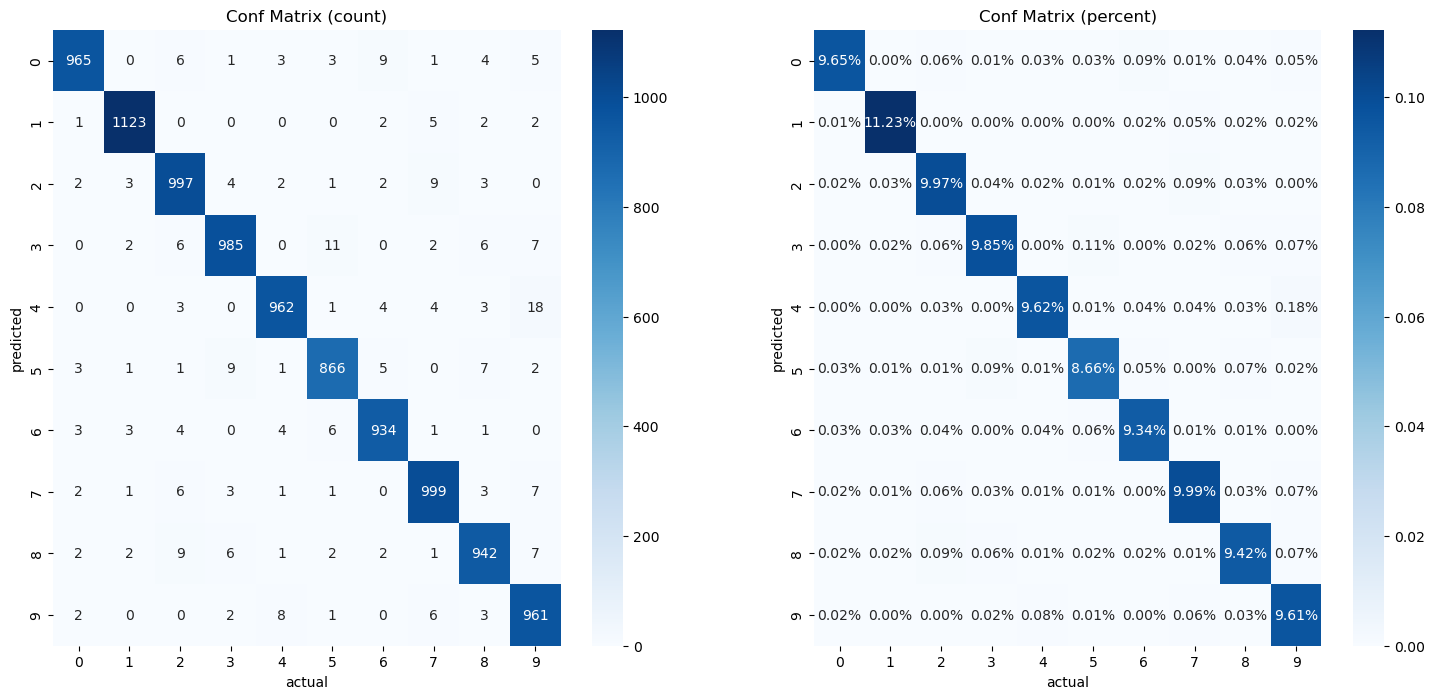

In [14]:
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=labels_num)
confmat = confmat(y_test, torch.tensor(yhats))

fig, ax = plt.subplots(1,2,figsize=(18,8))

sns.heatmap(confmat, annot=True, fmt = '0.0f',
            cmap='Blues', ax = ax[0])
sns.heatmap(confmat/torch.sum(confmat), annot=True, 
            fmt='.2%', cmap='Blues', ax = ax[1])
        
ax[0].set_xlabel('actual')
ax[0].set_ylabel('predicted')
ax[0].set_title('Conf Matrix (count)')
ax[1].set_xlabel('actual')
ax[1].set_ylabel('predicted')
ax[1].set_title('Conf Matrix (percent)')

plt.show()

One can print some information about weights and biases in learned model using ''.summary()'' and ''.diagnostics()''. 

In [15]:
# mcmc.diagnostics()
# mcmc.summary()

The code above is commented to avoid output congestion.

Although R-hat statistic (or estimated scale reduction) will be computed to check, whether the model's parameters has converged or not.

Simply put, if the mentioned statistic is near $1$, it means, that sampled values are close to the target distribution.

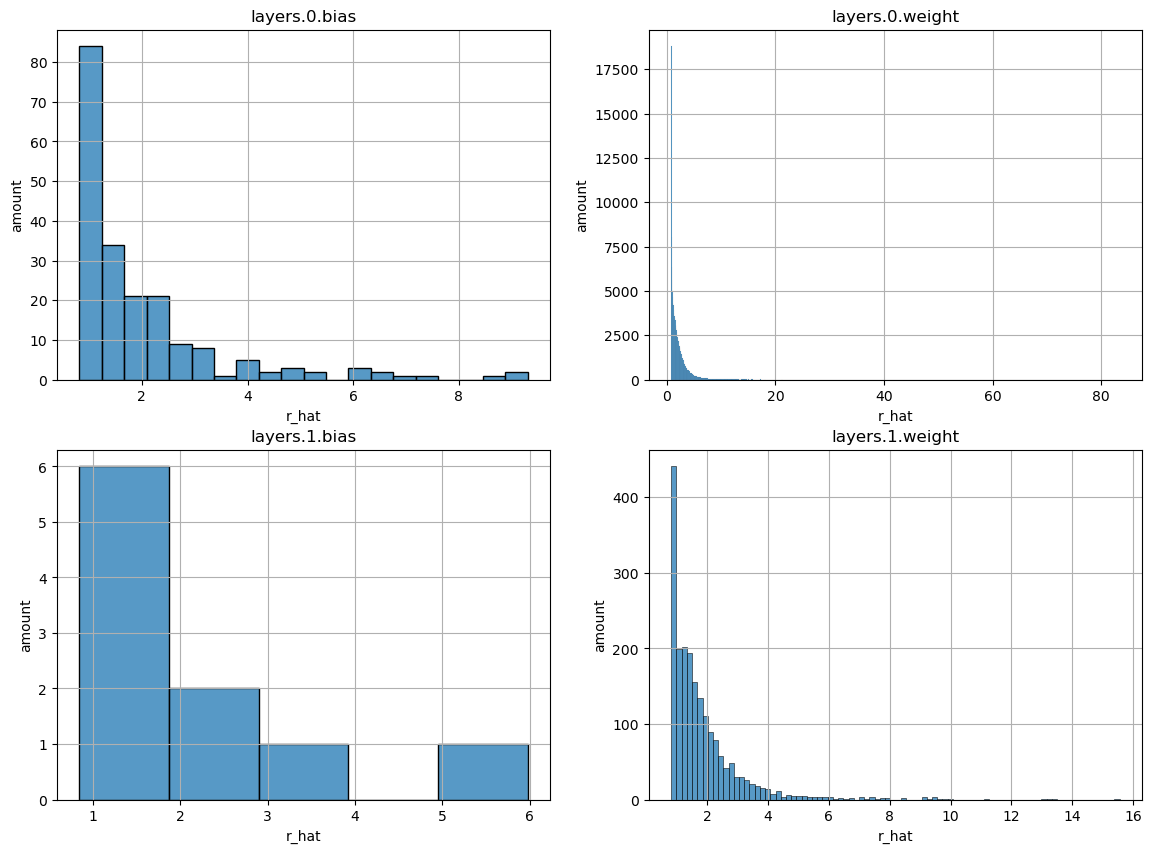

In [16]:
fig, ax = plt.subplots(round(len(posterior_samples.keys())/2),2,figsize=(14,10))

for index, param_name in enumerate(posterior_samples.keys()):
    r_hat_array = np.array(mcmc.diagnostics()[param_name]['r_hat'].detach().cpu()).flatten()
    sns.histplot(data = r_hat_array, ax = ax[int(index/2)][index%2])
    ax[int(index/2)][index%2].set_xlabel('r_hat')
    ax[int(index/2)][index%2].set_ylabel('amount')
    ax[int(index/2)][index%2].set_title(param_name)
    ax[int(index/2)][index%2].grid()

plt.show()

### Robustness check

Let us constuct noised validation dataset and then check the model results on such a set

We will add additional gaussian noise to our data

In [17]:
x_test_noised = np.minimum(x_test + (torch.randn_like(x_test)*20 + 100), 255)

Display the noised number

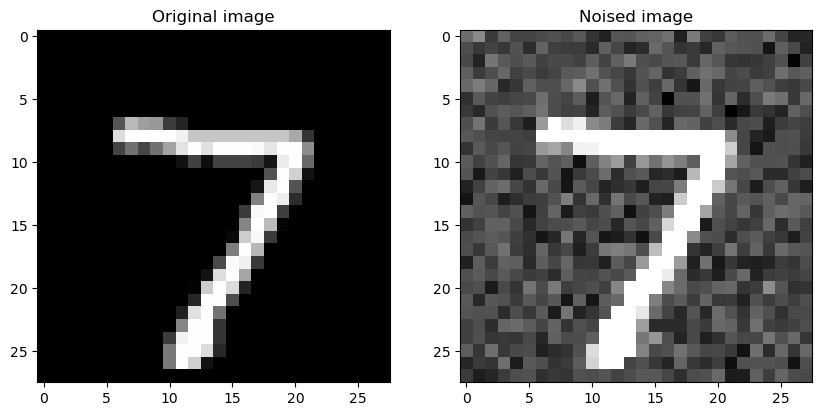

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,8))

ax[0].imshow(x_test[0].reshape(28,28), cmap='gray')
ax[1].imshow(x_test_noised[0].reshape(28,28), cmap='gray')

ax[0].set_title('Original image')
ax[1].set_title('Noised image')

plt.show()

Now let us use the previous methods to estimate the results of our model on noised validation set

Averaged accuracy: 0.9599999189376831
Class accuracy: tensor([0.9757, 0.9927, 0.9668, 0.9257, 0.9634, 0.9523, 0.9627, 0.9636, 0.9490,
        0.9457])
Class F-1: tensor([0.9792, 0.9763, 0.9630, 0.9437, 0.9644, 0.9464, 0.9662, 0.9584, 0.9524,
        0.9476])


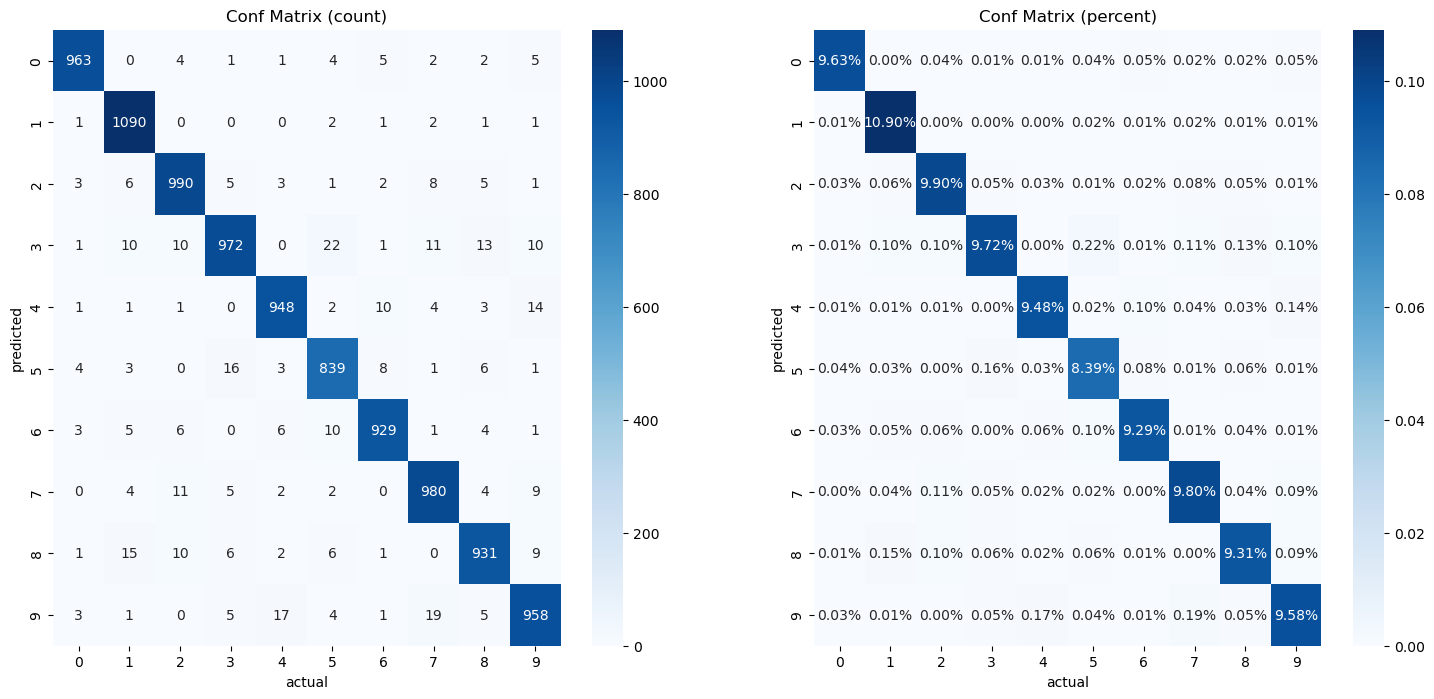

In [19]:
# Getting labels from noised data
predictive_noised = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds_noised = predictive_noised(x_test_noised)
yhats_noised = np.array([np.bincount(np.array(el).astype(int)).argmax() for el in preds_noised['obs'].transpose(1,0)])

# Computing accuracy and F-1 scores
av_acc = MulticlassAccuracy(num_classes = labels_num, average='weighted')
print(f"Averaged accuracy: {av_acc(y_test, torch.tensor(yhats_noised))}")
class_acc = MulticlassAccuracy(num_classes = labels_num, average='none')
print(f"Class accuracy: {class_acc(y_test, torch.tensor(yhats_noised))}")
class_acc = MulticlassF1Score(num_classes = labels_num, average='none')
print(f"Class F-1: {class_acc(y_test, torch.tensor(yhats_noised))}")

# Computing confusion matrix
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=labels_num).to('cpu')
confmat = confmat(y_test.clone().detach().to('cpu'), torch.tensor(yhats_noised).to('cpu'))

# Plotting confusion matrix
fig, ax = plt.subplots(1,2,figsize=(18,8))
sns.heatmap(confmat, annot=True, fmt = '0.0f',
            cmap='Blues', ax = ax[0])
sns.heatmap(confmat/torch.sum(confmat), annot=True, 
            fmt='.2%', cmap='Blues', ax = ax[1])
ax[0].set_xlabel('actual')
ax[0].set_ylabel('predicted')
ax[0].set_title('Conf Matrix (count)')
ax[1].set_xlabel('actual')
ax[1].set_ylabel('predicted')
ax[1].set_title('Conf Matrix (percent)')

plt.show()